# CubicGalileonEmu

> GP emulator for boost factor in cubic Galileon gravity model

Modified Gravity emulator for boost in the dark matter power spectra

## Install

(not installable yet)
```sh
pip install CubicGalileonEmu
```

## Basic rundown

### A few imports 

In [1]:
from CubicGalileonEmu.load import *
from CubicGalileonEmu.viz import *
from CubicGalileonEmu.pca import *
from CubicGalileonEmu.gp import *
from CubicGalileonEmu.emu import *
from CubicGalileonEmu.mcmc import *

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

### Loading files

In [2]:
Bk_all, k_all, z_all = load_boost_training()
p_all = load_params()

exclude = 35
Bk_all = np.delete(Bk_all, exclude, axis=0)
p_all = np.delete(p_all, exclude, axis=0)

### A few plotting routines

#### Experimental design

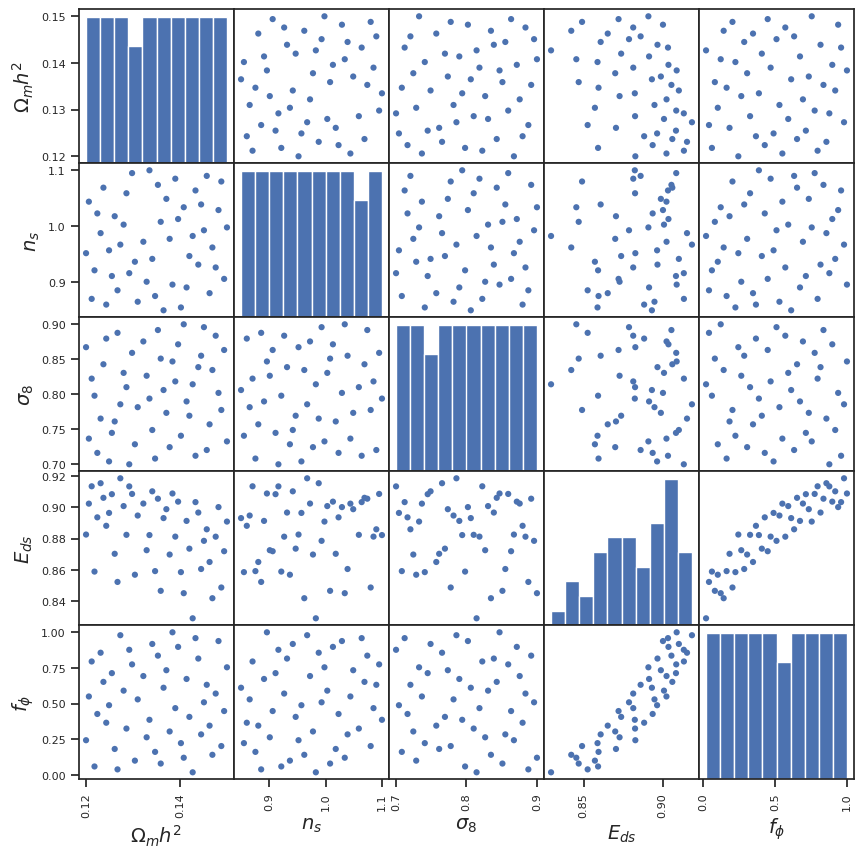

In [3]:
df_train_a = pd.DataFrame(p_all, columns=PARAM_NAME)
colors = ['b']*p_all.shape[0]
# colors = ['b']*num_sims + ['r']*num_sims_test
plot_scatter_matrix(df_train_a, colors);

#### Boost metrics colored by cosmology parameters

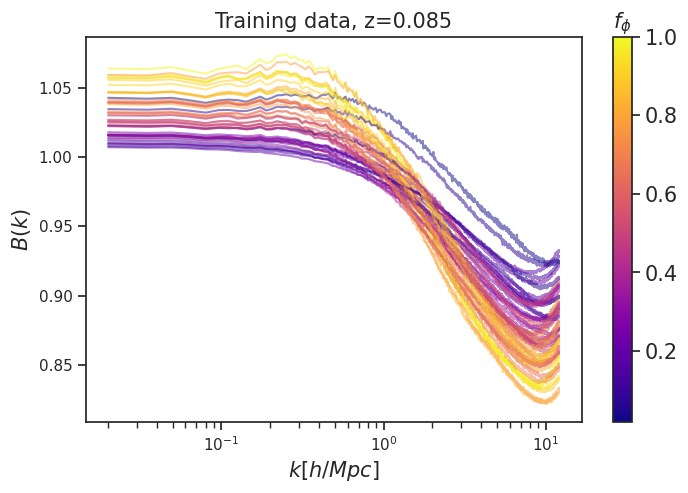

In [4]:
color_by_index = 4
z_index = 0

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

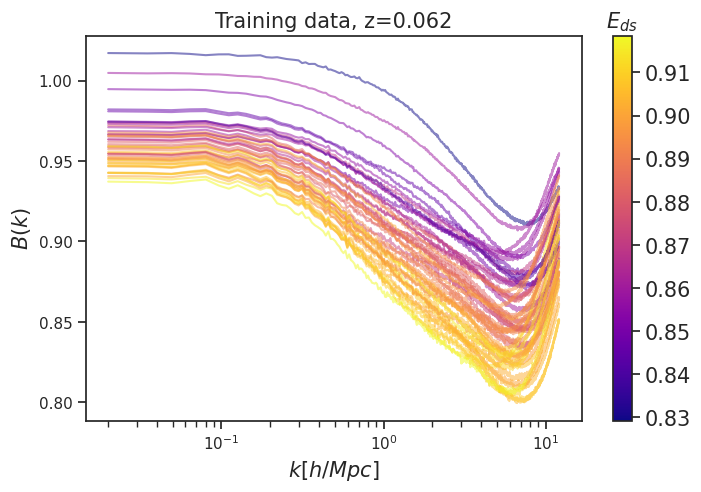

In [5]:
color_by_index = 3
z_index = 21

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

### Training involves: PCA, GP fitting.  

In [6]:
## Data prep
z_index = 1
y_vals = Bk_all[:, z_index, :]
# y_ind = np.arange(0, y_vals.shape[1])
y_ind = k_all

# Train-test split
test_indices = [0, 14, 35]
input_params= p_all[test_indices]
target_vals = Bk_all[:, z_index, :][test_indices]

train_indices = [i for i in  np.arange(49) if i not in test_indices] 
p_all_train = p_all[train_indices]
y_vals_train = Bk_all[:, z_index, :][train_indices]

In [7]:
sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind)
print(sepia_data)
model_filename = '../CubicGalileonEmu/model/multivariate_model_z_index' + str(z_index) 

sepia_model = do_pca(sepia_data, exp_variance=0.95)
sepia_model = do_gp_train(sepia_model, model_filename)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    46 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.22775415 0.49169025]
 [0.54280189 0.56107475]
 [0.09234195 0.0452624 ]
 [0.22315256 0.17902428]
 [0.79430577 0.15405721]
 [0.10443076 1.46359682]]
lamUz
[[0.641432   0.75679661]]
lamWs
[[4733.34571    4497.61173918]]
lamWOs
[[5.20322027]]


MCMC sampling: 100%|██████████| 1000/1000 [00:06<00:00, 158.47it/s]

Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index1.pkl


### Load existing model

In [8]:
sepia_model = gp_load(sepia_model, model_filename)

No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

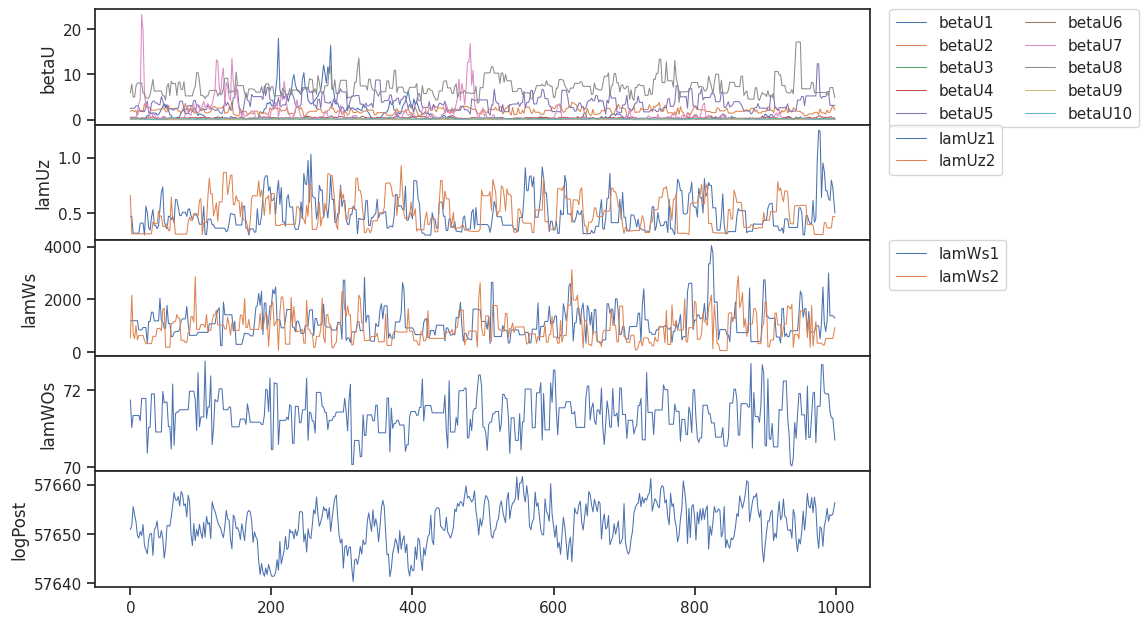

In [9]:
plot_train_diagnostics(sepia_model)

### Single-redshift emulation for new cosmological parameters

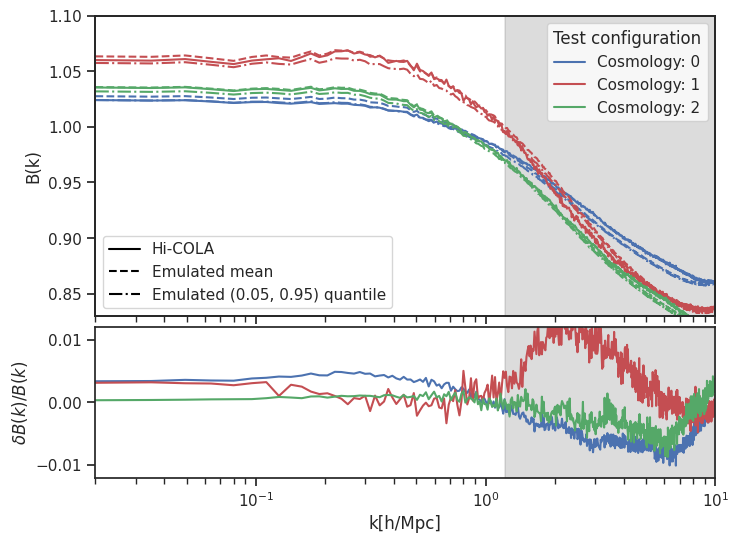

In [10]:
pred_mean, pred_quant = emulate(sepia_model, input_params)
validation_plot(k_all, target_vals, pred_mean, pred_quant);

### Sensitivity analysis from the emulator 

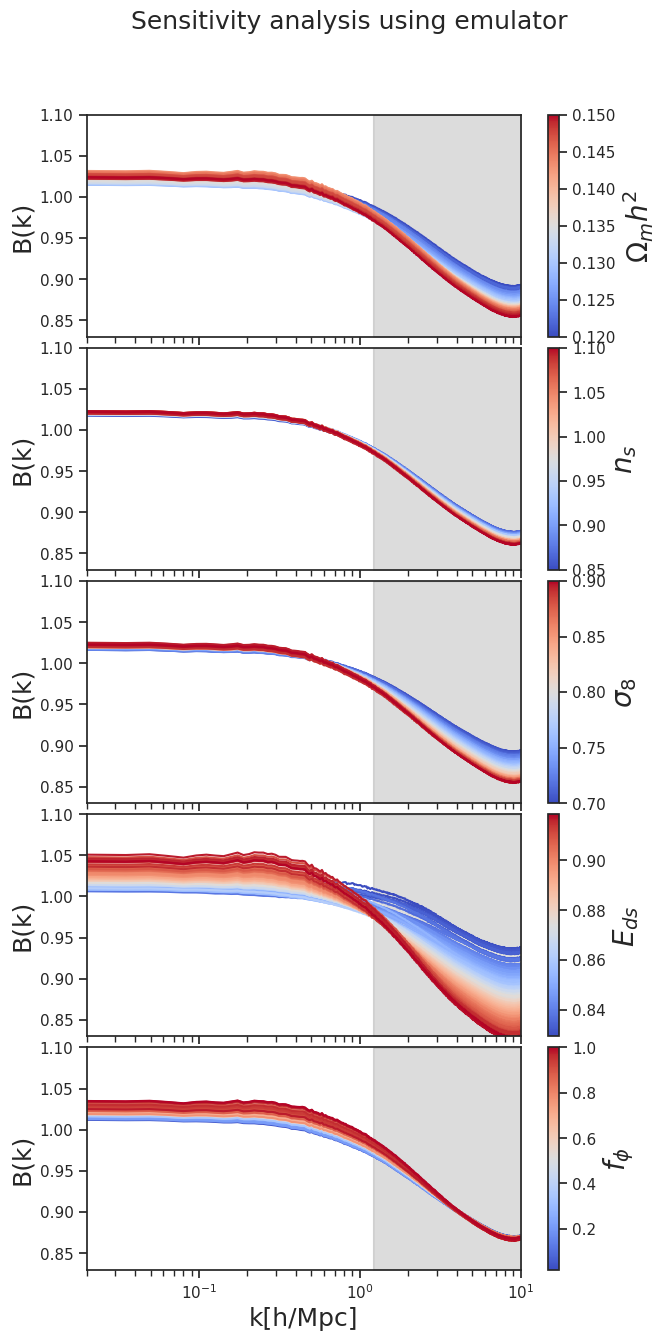

In [11]:
f = sensitivity_plot(k_all, p_all, sepia_model, emulate, PARAM_NAME)

### Multi-redshift emulation (not part of the emulator yet)

#### Train all the models

In [12]:
do_gp_train_multiple(model_dir='../CubicGalileonEmu/model/', 
                     p_train_all = p_all[train_indices],
                     y_vals_all = Bk_all[train_indices],
                     y_ind_all = k_all,
                     z_index_range=np.arange(50, 51))

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.19892545 1.871007  ]
 [0.57363013 0.32551549]
 [0.0564279  0.10567559]
 [0.12050523 0.50313074]
 [0.65790801 0.88418818]
 [0.07503551 0.39021501]]
lamUz
[[1.07870168 0.63063447]]
lamWs
[[3471.2397942  2208.14948592]]
lamWOs
[[0.07535804]]


MCMC sampling: 100%|██████████| 1000/1000 [00:06<00:00, 157.51it/s]

Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index50.pkl
Training complete for snapshot 50
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


In [13]:
sepia_model_list = load_model_multiple(model_dir='../CubicGalileonEmu/model/', 
                                       p_train_all=p_all,
                                       y_vals_all=Bk_all,
                                       y_ind_all=y_ind,
                                       z_index_range=range(51), 
                                       sepia_model_i=sepia_model)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (nu

In [14]:
input_params0 = input_params[0]
z_inputs = 0.1234
input_params_and_redshift = np.append(input_params0, z_inputs)

In [15]:
emulated_with_redshift, emulated_with_redshift_err = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)

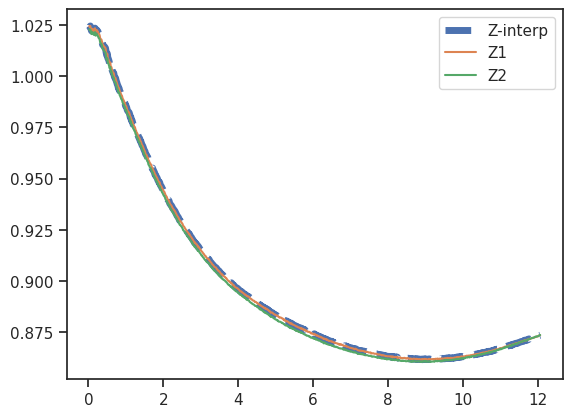

In [16]:
plt.plot(k_all, emulated_with_redshift[:, 0], label='Z-interp', lw=5, ls='--')
plt.plot(k_all, emulate(sepia_model_list[2], input_params_and_redshift[:-1])[0], label='Z1')
plt.plot(k_all, emulate(sepia_model_list[3], input_params_and_redshift[:-1])[0], label='Z2')
plt.legend()
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))

### Parameter inference using the emulator (not implemented yet)

In [17]:
ndim = 5
nwalkers = 300  # 500
nrun_burn = 300  # 300
nrun = 700  # 700

In [18]:
target_indx = 23
z_index = 1
L = 128

x_grid = k_all
x = k_all
y = Bk_all[:, z_index, :][target_indx]
yerr = np.sqrt( Bk_all[:, z_index, :][target_indx] *(L**3) )/(L**3)
params_calib = p_all[target_indx][:, np.newaxis].T

In [19]:
allMax = np.max(p_all, axis = 0)
allMin = np.min(p_all, axis = 0)

param1 = [PARAM_NAME[0], params_calib[0][0], allMin[0], allMax[0]] # Actual 0.119
param2 = [PARAM_NAME[1], params_calib[0][1], allMin[1], allMax[1]]
param3 = [PARAM_NAME[2], params_calib[0][2], allMin[2], allMax[2]]
param4 = [PARAM_NAME[3], params_calib[0][3], allMin[3], allMax[2]]
param5 = [PARAM_NAME[3], params_calib[0][3], allMin[4], allMax[4]]

params_list = [param1, param2, param3, param4, param5]
redshift = 0.01
theta = np.array([0.1218, 0.9214, 0.798, 0.85906746, 0.06122])

In [20]:
ln_prob(theta, redshift, params_list, x_grid, sepia_model_list, z_all, x_grid, y, yerr)

6.9889431061020115

In [21]:
params_list

[['$\\Omega_m h^2$', 0.1218, 0.12, 0.15],
 ['$n_s$', 0.9214, 0.85, 1.1],
 ['$\\sigma_8$', 0.798, 0.7, 0.9],
 ['$E_{ds}$', 0.8590674630925081, 0.8292872507980129, 0.9],
 ['$E_{ds}$', 0.8590674630925081, 0.02041, 1.0]]

In [22]:
pos0 = chain_init(params_list, ndim, nwalkers)
sampler = define_sampler(redshift, ndim, nwalkers, params_list, x_grid, sepia_model_list, z_all, x, y, yerr)

In [23]:
pos, prob, state, samples, sampler = do_mcmc(sampler, pos0, nrun, ndim, if_burn=True)
pos, prob, state, samples, sampler = do_mcmc(sampler, pos, nrun, ndim, if_burn=False)
p_mcmc = mcmc_results(samples)

/home/nramachandra/anaconda3/envs/qom_torch_tf/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


burn-in time: 2442.9009399414062
burn-in time: 2404.2191667556763
mcmc results: 0.13350664944457477 0.9644765448936333 0.7834745699649206 0.853882247885067 0.507308608441241


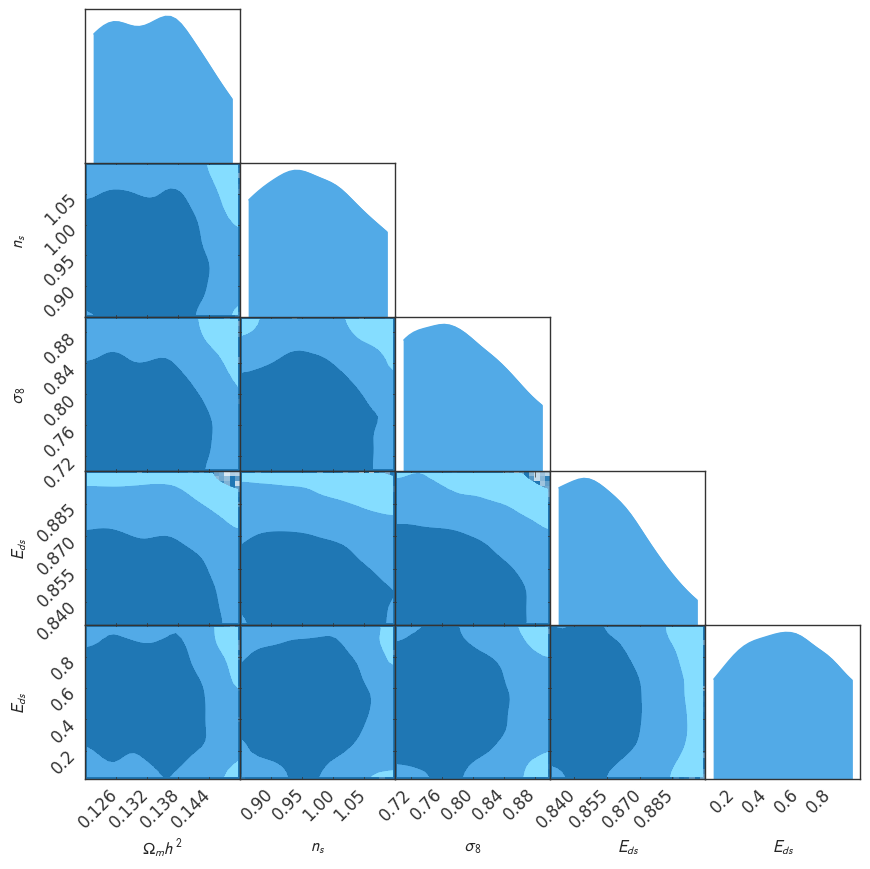

In [24]:
fig = plot_mcmc(samples, params_list, if_truth_know=False)